# Imitation Learning for Portfolio Management using CNN

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [1]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index
import matplotlib.pyplot as plt

# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

%env DATABASE_NAME=timescaledb
%env DATABASE_HOST=localhost
%env DATABASE_PORT=5432
%env DATABASE_USER=timescaledb
%env DATABASE_PASSWORD=yourmomasofat

env: DATABASE_NAME=timescaledb
env: DATABASE_HOST=localhost
env: DATABASE_PORT=5432
env: DATABASE_USER=timescaledb
env: DATABASE_PASSWORD=yourmomasofat


In [2]:
# force tensorflow to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow_io as tfio
import tensorflow as tf

endpoint="postgresql://{}:{}@{}?port={}&dbname={}".format(
    os.environ['DATABASE_USER'],
    os.environ['DATABASE_PASSWORD'],
    os.environ['DATABASE_HOST'],
    os.environ['DATABASE_PORT'],
    os.environ['DATABASE_NAME'],
)

In [ ]:
#dataset: (num_stocks, timestamp, 5) open, high, low, close, volume


In [3]:
query_1 = "SELECT extract(epoch from time) AS time, open FROM ohlc_candleseries WHERE symbol = 'LTC/USDT' LIMIT 2000;"

query_tmp = "SELECT extract(epoch from time) AS time, open FROM ohlc_candleseries WHERE symbol = '{}' LIMIT {};"


query_2 = """
SELECT
    extract(epoch from time) AS time,
    array[
            MAX(open) FILTER (WHERE symbol = 'BTC/USDT'),
            MAX(high) FILTER (WHERE symbol = 'BTC/USDT'),
            MAX(low) FILTER (WHERE symbol = 'BTC/USDT'),
            MAX(close) FILTER (WHERE symbol = 'BTC/USDT')
    ] AS btc,
    array[
            MAX(open) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(high) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(low) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(close) FILTER (WHERE symbol = 'LTC/USDT')
    ] AS ltc

FROM ohlc_candleseries
GROUP BY extract(epoch from time)
LIMIT 2000
"""
query = """
SELECT
    extract(epoch from time) AS time,
    json_build_array(
                MAX(open) FILTER (WHERE symbol = 'BTC/USDT'),
                MAX(high) FILTER (WHERE symbol = 'BTC/USDT'),
                MAX(low) FILTER (WHERE symbol = 'BTC/USDT'),
                MAX(close) FILTER (WHERE symbol = 'BTC/USDT')
    ) AS btc,
    json_build_array(
            MAX(open) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(high) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(low) FILTER (WHERE symbol = 'LTC/USDT'),
            MAX(close) FILTER (WHERE symbol = 'LTC/USDT')
    ) AS ltc

FROM ohlc_candleseries
GROUP BY extract(epoch from time)
LIMIT 2000
"""


dataset = tfio.experimental.IODataset.from_sql(
    query=query,
    endpoint=endpoint,
    spec=(tf.int16, (tf.int16, tf.int16, tf.int16, tf.int16), (tf.int16, tf.int16, tf.int16, tf.int16))
)

# print(dataset.element_spec)

2022-12-11 16:30:09.596928: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-12-11 16:30:09.857014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 16:30:09.903723: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-11 16:30:11.952111: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.
2022-12-11 16:30:11.952198: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at sql_kernels.cc:178 : INVALID_ARGUMENT: OID of data type 114 is not supported


InvalidArgumentError: OID of data type 114 is not supported [Op:IO>SqlIterableInit]

In [46]:
_ = tfio.experimental.IODataset.from_sql(
    query=query_tmp.format('BTC/USDT', 200),
    endpoint=endpoint,
).batch(50).shuffle(9).take(1).batch(5)

2022-12-11 17:44:14.805806: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-11 17:44:15.166484: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.


In [154]:
ds = tf.data.Dataset.from_tensor_slices({
    'x': [1, 2, 3, 4, 5, 6, 7, 8 , 9 ],
    'l': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i' ]
}).batch(6).take(1)

ds.element_spec

{'x': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
 'l': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [155]:
to_numpy(ds)

[{'x': array([1, 2, 3, 4, 5, 6], dtype=int32),
  'l': array([b'a', b'b', b'c', b'd', b'e', b'f'], dtype=object)}]

In [159]:
to_numpy(tf.data.Dataset.zip(ds))

[{'x': array([1, 2, 3, 4, 5, 6], dtype=int32),
  'l': array([b'a', b'b', b'c', b'd', b'e', b'f'], dtype=object)}]

In [385]:
tf.compat.v1.enable_eager_execution()

a = tf.data.Dataset.range(1, 50)
b = tf.data.Dataset.range(50, 150)
ds = tf.data.Dataset.zip({'a': a, 'b': b})

ds = ds.window(5, shift=1, stride=1, drop_remainder=True)

for w in ds:
    print(list(w['a'].as_numpy_iterator()), '|', list(w['b'].as_numpy_iterator()))



2022-12-13 23:53:05.751327: W tensorflow/core/framework/dataset.cc:744] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


[1, 2, 3, 4, 5] | [50, 51, 52, 53, 54]
[2, 3, 4, 5, 6] | [51, 52, 53, 54, 55]
[3, 4, 5, 6, 7] | [52, 53, 54, 55, 56]
[4, 5, 6, 7, 8] | [53, 54, 55, 56, 57]
[5, 6, 7, 8, 9] | [54, 55, 56, 57, 58]
[6, 7, 8, 9, 10] | [55, 56, 57, 58, 59]
[7, 8, 9, 10, 11] | [56, 57, 58, 59, 60]
[8, 9, 10, 11, 12] | [57, 58, 59, 60, 61]
[9, 10, 11, 12, 13] | [58, 59, 60, 61, 62]
[10, 11, 12, 13, 14] | [59, 60, 61, 62, 63]
[11, 12, 13, 14, 15] | [60, 61, 62, 63, 64]
[12, 13, 14, 15, 16] | [61, 62, 63, 64, 65]
[13, 14, 15, 16, 17] | [62, 63, 64, 65, 66]
[14, 15, 16, 17, 18] | [63, 64, 65, 66, 67]
[15, 16, 17, 18, 19] | [64, 65, 66, 67, 68]
[16, 17, 18, 19, 20] | [65, 66, 67, 68, 69]
[17, 18, 19, 20, 21] | [66, 67, 68, 69, 70]
[18, 19, 20, 21, 22] | [67, 68, 69, 70, 71]
[19, 20, 21, 22, 23] | [68, 69, 70, 71, 72]
[20, 21, 22, 23, 24] | [69, 70, 71, 72, 73]
[21, 22, 23, 24, 25] | [70, 71, 72, 73, 74]
[22, 23, 24, 25, 26] | [71, 72, 73, 74, 75]
[23, 24, 25, 26, 27] | [72, 73, 74, 75, 76]
[24, 25, 26, 27, 28] | 

In [392]:
a = tf.data.Dataset.range(1, 50)
b = tf.data.Dataset.range(50, 150)
ds = tf.data.Dataset.zip({'a': a, 'b': b})

ds = ds.window(5, shift=1, stride=1, drop_remainder=True).flat_map(lambda x: tf.data.Dataset.zip({'a': x['a'], 'b': x['b']}).batch(5)).batch(5)
b=0
for w in ds:
    # print(w)
    b+=1
    print('batch : ', b)
    print(w)
    # print(w['a'], '|',w['b'])


batch :  1
{'a': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]])>, 'b': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[50, 51, 52, 53, 54],
       [51, 52, 53, 54, 55],
       [52, 53, 54, 55, 56],
       [53, 54, 55, 56, 57],
       [54, 55, 56, 57, 58]])>}
batch :  2
{'a': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12],
       [ 9, 10, 11, 12, 13],
       [10, 11, 12, 13, 14]])>, 'b': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[55, 56, 57, 58, 59],
       [56, 57, 58, 59, 60],
       [57, 58, 59, 60, 61],
       [58, 59, 60, 61, 62],
       [59, 60, 61, 62, 63]])>}
batch :  3
{'a': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[11, 12, 13, 14, 15],
       [12, 13, 14, 15, 16],
       [13, 14, 15, 16, 17],
       [14, 15, 16, 17, 18],
       [15, 16, 17, 18, 19

In [298]:
# Create a window of size 3, with a shift of 1 and a stride of 1
ds = ds.window(3, shift=1, stride=1)

# Iterate through the batches in the dataset
for batch in ds:
    # Iterate through the windows in the batch
    for window in batch:
      # Print the windowed dataset
      print(window)

a
b
a
b


In [388]:
a = tf.data.Dataset.range(1, 16)
b = tf.data.Dataset.range(16, 32)
# zipped = tf.data.Dataset.zip((a, b))
ds = tf.data.Dataset.zip({'a': a, 'b': b})

ds = ds[0:7]
# ds = ds.map()

list(ds.as_numpy_iterator())

TypeError: 'ZipDataset' object is not subscriptable

In [348]:
ds = ds.batch(8, drop_remainder=True)
# list(batched_dataset.take(1).unbatch().as_numpy_iterator())
# ds = ds.map(lambda b: b.batch(8))

for ub in ds:
    print('ub')
    print(ub)
    windows_ub = ub.window(3, shift=1, stride=1, drop_remainder=True)
    print('windows_ub')
    print(windows_ub)

ub
{'a': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 2, 3, 4, 5, 6, 7, 8])>, 'b': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([16, 17, 18, 19, 20, 21, 22, 23])>}


AttributeError: 'dict' object has no attribute 'window'

In [311]:
for ub in batched_dataset.unbatch():
    print(ub)

{'a': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=16>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=17>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=18>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=19>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=5>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=20>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=6>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=21>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=7>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=22>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=8>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=23>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'b': <tf.Tensor: shape=(), dtype=int64, numpy=24>}
{'a': <tf.Tensor: shape=(), dtype=int64, numpy=10>, 'b': <tf.Tensor: shape=(), dty

In [301]:
batches = zipped.batch(9)
for b in batches.take(1):
    print(b['a'], '|', b['b'])
    # print(list(w['a'].as_numpy_iterator()), ', ' ,list(w['b'].as_numpy_iterator()))

tf.Tensor([1 2 3 4 5 6 7 8 9], shape=(9,), dtype=int64) | tf.Tensor([16 17 18 19 20 21 22 23 24], shape=(9,), dtype=int64)


In [260]:

windows = zipped.window(3, shift=1, stride=1)

for w in windows.take(1):
    print(list(w['a'].as_numpy_iterator()), ', ' ,list(w['b'].as_numpy_iterator()))
    # print(tf.nest.map_structure(to_numpy, w))

[1, 2, 3] ,  [16, 17, 18]


In [250]:
windows = zipped.window(3, shift=1, stride=1).flat_map(lambda a ,b : tf.data.Dataset.zip((a, b)).batch(3))
for w in windows.take(2):
    # print(w.numpy())
    tf.nest.map_structure(to_numpy, w)
  # print(w.as_numpy_iterator())

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'as_numpy_iterator'

In [202]:
list(windows.as_numpy_iterator())

[(1, 16),
 (2, 17),
 (3, 18),
 (2, 17),
 (3, 18),
 (4, 19),
 (3, 18),
 (4, 19),
 (5, 20),
 (4, 19),
 (5, 20),
 (6, 21),
 (5, 20),
 (6, 21),
 (7, 22),
 (6, 21),
 (7, 22),
 (8, 23),
 (7, 22),
 (8, 23),
 (9, 24),
 (8, 23),
 (9, 24),
 (10, 25),
 (9, 24),
 (10, 25),
 (11, 26),
 (10, 25),
 (11, 26),
 (12, 27),
 (11, 26),
 (12, 27),
 (13, 28),
 (12, 27),
 (13, 28),
 (14, 29),
 (13, 28),
 (14, 29),
 (15, 30),
 (14, 29),
 (15, 30),
 (15, 30)]

In [176]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):

  windows = ds.window(window_size, shift=shift, stride=stride, drop_remainder=True)

  def sub_to_batch(sub):

    print('sub : ', sub)
    print('type(sub) : ', type(sub))

    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)

  return windows

In [180]:
make_window_dataset(zipped)

sub :  {'a': <_VariantDataset shapes: (), types: tf.int64>, 'b': <_VariantDataset shapes: (), types: tf.int64>}
type(sub) :  <class 'dict'>


AttributeError: in user code:

    File "/var/folders/nb/493_knds4wb1xy3lp5v1c8b40000gn/T/ipykernel_81092/760946245.py", line 10, in sub_to_batch  *
        return sub.batch(window_size, drop_remainder=True)

    AttributeError: 'dict' object has no attribute 'batch'


In [174]:
list(zipped.window(3, shift=1, stride=1).as_numpy_iterator())

TypeError: `tf.data.Dataset.as_numpy_iterator()` is not supported for datasets that produce values of type <class 'tensorflow.python.data.ops.dataset_ops.DatasetV2'>

In [164]:
batched = zipped.batch(4, drop_remainder=True).take(1)
list(batched.as_numpy_iterator())


[(array([1, 2, 3, 4]), array([16, 17, 18, 19]))]

In [124]:

windows = ds.window(3, shift=1, stride=1)
def to_numpy(ds):
  return list(ds.as_numpy_iterator())

for w in windows:
  print(tf.nest.map_structure(to_numpy, w))



{'x': [array([1, 2, 3, 4, 5, 6], dtype=int32)], 'l': [array([b'a', b'b', b'c', b'd', b'e', b'f'], dtype=object)]}


2022-12-11 22:56:41.531924: W tensorflow/core/framework/dataset.cc:744] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [181]:
ds = tf.data.Dataset.from_tensor_slices({
    'x': [1, 2, 3, 4, 5, 6, 7, 8 , 9 ],
    'l': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i' ]
})
# }).batch(6).take(1)

ds.element_spec

{'x': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'l': TensorSpec(shape=(), dtype=tf.string, name=None)}

In [135]:
to_numpy(ds)


[{'x': 1, 'l': b'a'},
 {'x': 2, 'l': b'b'},
 {'x': 3, 'l': b'c'},
 {'x': 4, 'l': b'd'},
 {'x': 5, 'l': b'e'},
 {'x': 6, 'l': b'f'},
 {'x': 7, 'l': b'g'},
 {'x': 8, 'l': b'h'},
 {'x': 9, 'l': b'i'}]

In [186]:
windows = ds.window(3, shift=1, stride=1)
for w in windows:
    # print(w.to_numpy())
  print(tf.nest.map_structure(to_numpy, w))

{'x': [1, 2, 3], 'l': [b'a', b'b', b'c']}
{'x': [2, 3, 4], 'l': [b'b', b'c', b'd']}
{'x': [3, 4, 5], 'l': [b'c', b'd', b'e']}
{'x': [4, 5, 6], 'l': [b'd', b'e', b'f']}
{'x': [5, 6, 7], 'l': [b'e', b'f', b'g']}
{'x': [6, 7, 8], 'l': [b'f', b'g', b'h']}
{'x': [7, 8, 9], 'l': [b'g', b'h', b'i']}
{'x': [8, 9], 'l': [b'h', b'i']}
{'x': [9], 'l': [b'i']}


In [146]:
for w in windows.batch(6):
  print(w)

{'x': <tensorflow.python.data.ops.dataset_ops._NestedVariant object at 0x14a1be910>, 'l': <tensorflow.python.data.ops.dataset_ops._NestedVariant object at 0x14a1bee80>}
{'x': <tensorflow.python.data.ops.dataset_ops._NestedVariant object at 0x14a1be820>, 'l': <tensorflow.python.data.ops.dataset_ops._NestedVariant object at 0x14a1be580>}


In [151]:
ds = tf.data.Dataset.from_tensor_slices(
    ([1, 2, 3, 4, 5, 6, 7, 8 , 9 ],['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i' ])
# )
).batch(6).take(1)

ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.int32, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

In [152]:
to_numpy(ds)

[(array([1, 2, 3, 4, 5, 6], dtype=int32),
  array([b'a', b'b', b'c', b'd', b'e', b'f'], dtype=object))]

In [153]:
windows = ds.window(3, shift=1, stride=1)
for w in windows:
  print(tf.nest.map_structure(to_numpy, w))

([array([1, 2, 3, 4, 5, 6], dtype=int32)], [array([b'a', b'b', b'c', b'd', b'e', b'f'], dtype=object)])


2022-12-11 23:32:37.084974: W tensorflow/core/framework/dataset.cc:744] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [79]:
dataset = tfio.experimental.IODataset.from_sql(
    query=query_tmp.format('BTC/USDT', 200),
    endpoint=endpoint,
# )
).batch(50).shuffle(9).take(1)

2022-12-11 21:54:28.941879: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-11 21:54:29.137967: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.


In [80]:
dataset.element_spec

{'time': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'open': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}

In [86]:
for element in dataset:
  print(element)

{'time': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1.66500834e+09, 1.66500828e+09, 1.66500822e+09, 1.66500816e+09,
       1.66500810e+09, 1.66500804e+09, 1.66500798e+09, 1.66500792e+09,
       1.66500786e+09, 1.66500780e+09, 1.66500774e+09, 1.66500768e+09,
       1.66500762e+09, 1.66500756e+09, 1.66500750e+09, 1.66500744e+09,
       1.66500738e+09, 1.66500732e+09, 1.66500726e+09, 1.66500720e+09,
       1.66500714e+09, 1.66500708e+09, 1.66500702e+09, 1.66500696e+09,
       1.66500690e+09, 1.66500684e+09, 1.66500678e+09, 1.66500672e+09,
       1.66500666e+09, 1.66500660e+09, 1.66500654e+09, 1.66500648e+09,
       1.66500642e+09, 1.66500636e+09, 1.66500630e+09, 1.66500624e+09,
       1.66500618e+09, 1.66500612e+09, 1.66500606e+09, 1.66500600e+09,
       1.66500594e+09, 1.66500588e+09, 1.66500582e+09, 1.66500576e+09,
       1.66500570e+09, 1.66500564e+09, 1.66500558e+09, 1.66500552e+09,
       1.66500546e+09, 1.66500540e+09])>, 'open': <tf.Tensor: shape=(50,), dtype=float64, nu

In [92]:
list(dataset.as_numpy_iterator())

[{'time': array([1.66500534e+09, 1.66500528e+09, 1.66500522e+09, 1.66500516e+09,
         1.66500510e+09, 1.66500504e+09, 1.66500498e+09, 1.66500492e+09,
         1.66500486e+09, 1.66500480e+09, 1.66500474e+09, 1.66500468e+09,
         1.66500462e+09, 1.66500456e+09, 1.66500450e+09, 1.66500444e+09,
         1.66500438e+09, 1.66500432e+09, 1.66500426e+09, 1.66500420e+09,
         1.66500414e+09, 1.66500408e+09, 1.66500402e+09, 1.66500396e+09,
         1.66500390e+09, 1.66500384e+09, 1.66500378e+09, 1.66500372e+09,
         1.66500366e+09, 1.66500360e+09, 1.66500354e+09, 1.66500348e+09,
         1.66500342e+09, 1.66500336e+09, 1.66500330e+09, 1.66500324e+09,
         1.66500318e+09, 1.66500312e+09, 1.66500306e+09, 1.66500300e+09,
         1.66500294e+09, 1.66500288e+09, 1.66500282e+09, 1.66500276e+09,
         1.66500270e+09, 1.66500264e+09, 1.66500258e+09, 1.66500252e+09,
         1.66500246e+09, 1.66500240e+09]),
  'open': array([20032.54, 20025.39, 20022.71, 20025.03, 20035.74, 20029.

In [87]:
def to_numpy(ds):
    l = list(ds.as_numpy_iterator())
    return l[0]

In [93]:
windows = dataset.window(5, shift=1, stride=1)

In [94]:
for w in windows:
    print(w)

{'time': <_VariantDataset shapes: (None,), types: tf.float64>, 'open': <_VariantDataset shapes: (None,), types: tf.float64>}


In [95]:
c = 0
for window in windows:
  c+=1
  print(c)
  print(tf.nest.map_structure(to_numpy, window))


1
{'time': array([1.66501434e+09, 1.66501428e+09, 1.66501422e+09, 1.66501416e+09,
       1.66501410e+09, 1.66501404e+09, 1.66501398e+09, 1.66501392e+09,
       1.66501386e+09, 1.66501380e+09, 1.66501374e+09, 1.66501368e+09,
       1.66501362e+09, 1.66501356e+09, 1.66501350e+09, 1.66501344e+09,
       1.66501338e+09, 1.66501332e+09, 1.66501326e+09, 1.66501320e+09,
       1.66501314e+09, 1.66501308e+09, 1.66501302e+09, 1.66501296e+09,
       1.66501290e+09, 1.66501284e+09, 1.66501278e+09, 1.66501272e+09,
       1.66501266e+09, 1.66501260e+09, 1.66501254e+09, 1.66501248e+09,
       1.66501242e+09, 1.66501236e+09, 1.66501230e+09, 1.66501224e+09,
       1.66501218e+09, 1.66501212e+09, 1.66501206e+09, 1.66501200e+09,
       1.66501194e+09, 1.66501188e+09, 1.66501182e+09, 1.66501176e+09,
       1.66501170e+09, 1.66501164e+09, 1.66501158e+09, 1.66501152e+09,
       1.66501146e+09, 1.66501140e+09]), 'open': array([20162.84, 20154.52, 20163.13, 20166.62, 20167.15, 20168.17,
       20176.92, 2016

2022-12-11 22:46:37.205176: W tensorflow/core/framework/dataset.cc:744] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [38]:
def sub_to_batch(sub):
  return sub.batch(5, drop_remainder=True)

In [39]:
for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

AttributeError: in user code:

    File "/var/folders/nb/493_knds4wb1xy3lp5v1c8b40000gn/T/ipykernel_81092/4091595652.py", line 2, in sub_to_batch  *
        return sub.batch(5, drop_remainder=True)

    AttributeError: 'dict' object has no attribute 'batch'


In [41]:
for example in windows.flat_map(lambda x : x).take(5):
  print(example.numpy())

TypeError: The `map_func` argument must return a `Dataset` object. Got <class 'dict'>.

In [50]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):

  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):

    print('sub : ', sub)
    print('type(sub) : ', type(sub))

    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)

  return windows

In [51]:
windowed_dataset = make_window_dataset(dataset)

sub :  {'time': <_VariantDataset shapes: (), types: tf.float64>, 'open': <_VariantDataset shapes: (), types: tf.float64>}
type(sub) :  <class 'dict'>


AttributeError: in user code:

    File "/var/folders/nb/493_knds4wb1xy3lp5v1c8b40000gn/T/ipykernel_81092/760946245.py", line 10, in sub_to_batch  *
        return sub.batch(window_size, drop_remainder=True)

    AttributeError: 'dict' object has no attribute 'batch'


In [13]:
window.take(1)

<TakeDataset shapes: {time: DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorShape([])), open: DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorShape([]))}, types: {time: DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorShape([])), open: DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorShape([]))}>

In [7]:
next(dataset.take(1).as_numpy_iterator())

{'time': array([1.66501434e+09, 1.66501428e+09, 1.66501422e+09, ...,
        1.66489452e+09, 1.66489446e+09, 1.66489440e+09]),
 'open': array([20162.84, 20154.52, 20163.13, ..., 20107.29, 20095.2 , 20075.02])}

In [185]:
dataset_btc = tfio.experimental.IODataset.from_sql(
    query="SELECT extract(epoch from time) AS time, open FROM ohlc_candleseries WHERE symbol = 'BTC/USDT' LIMIT 2000;",
    endpoint=endpoint,
)
dataset_ltc = tfio.experimental.IODataset.from_sql(
    query="SELECT extract(epoch from time) AS time, open FROM ohlc_candleseries WHERE symbol = 'LTC/USDT' LIMIT 2000;",
    endpoint=endpoint,
)

2022-12-10 23:44:25.181513: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-10 23:44:25.327798: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.
2022-12-10 23:44:25.562968: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-10 23:44:25.777863: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.


In [190]:
ds = tf.data.Dataset.zip((dataset_btc, dataset_ltc))
print(ds.take(1))


<TakeDataset shapes: ({time: (), open: ()}, {time: (), open: ()}), types: ({time: tf.float64, open: tf.float64}, {time: tf.float64, open: tf.float64})>


In [22]:
def construct_dataset(symbols=('BTC/USDT', 'ETH/USDT', 'LTC/USDT'), limit=1000):
    """
    helper to construct tf dataset.
    since we can only read 2D data from SQL, we need to zip multiple datasets to build 3D tensor
    """
    ENDPOINT ="postgresql://{}:{}@{}?port={}&dbname={}".format(
        os.environ['DATABASE_USER'],
        os.environ['DATABASE_PASSWORD'],
        os.environ['DATABASE_HOST'],
        os.environ['DATABASE_PORT'],
        os.environ['DATABASE_NAME'],
    )

    QUERY = "SELECT extract(epoch from time) AS time, open FROM ohlc_candleseries WHERE symbol = '{}' LIMIT {};"

    datasets = []

    for symbol in symbols:
        datasets.append(
            tfio.experimental.IODataset.from_sql(
                query=QUERY.format(symbol, limit),
                endpoint=ENDPOINT,
            )
        )

    print('created datasets')

    dataset =  tf.data.Dataset.zip(tuple(datasets))

    return dataset


In [206]:
tf.compat.v1.enable_eager_execution()

In [207]:
dataset = construct_dataset(symbols=('BTC/USDT', 'ETH/USDT', 'LTC/USDT'), limit=60000)

2022-12-10 23:58:08.705088: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-10 23:58:09.243605: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.
2022-12-10 23:58:09.373026: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.
2022-12-10 23:58:10.079177: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.
2022-12-10 23:58:10.147173: I tensorflow_io/core/kernels/sql_kernels.cc:89] Connection to database succeed.


created datasets


2022-12-10 23:58:11.072170: I tensorflow_io/core/kernels/sql_kernels.cc:96] Exec of query succeed.


In [208]:
current_batch = dataset.batch(3000).shuffle(9).take(1)

In [209]:
windows = current_batch.window(30, shift=1)

In [210]:
for window in windows:
  for val in window:
    print(val.numpy(), end=" ")

AttributeError: 'dict' object has no attribute 'numpy'

In [147]:
import copy

class DataGenerator(object):
    """Acts as data provider for each new episode."""

    def __init__(self, dataset, symbols, steps=30, window_size=14, batch_size=3000):
        """

        Args:
            dataset: (num_stocks, timestamp, 5) open, high, low, close, volume
            symbols: a list of length num_stocks with assets name
            steps: the total number of steps to simulate, default is 2 years
            window_size: observation window, must be less than 50

        """

        self.batch_size = batch_size
        self.steps = steps + 1
        self.n_episodes = int(self.batch_size / self.steps)
        self.step = 0
        self.window_size = window_size
        # make immutable class
        self._dataset = dataset
        self.current_batch = None
        self.windows_obs = None
        self.window_gt = None

        self.symbols = symbols
        self.cur_obs = None
        self.cur_gt = None

    def _step(self):
        self.step += 1
        self.cur_obs = next(self.windows_obs)
        self.cur_gt = next(self.windows_gt)

        done = self.step >= self.steps
        return self.cur_obs, done, self.cur_gt

    def reset(self):
        self.step = 0
        self.current_batch = self._dataset.batch(self.batch_size).shuffle(9).take(1)
        self.windows_obs = self.current_batch.window(self.window_size, shift=1)
        self.windows_gt = self.current_batch.window(self.window_size, shift=1)
        # increment for (future) gt observation
        # next(self.windows_gt)


In [148]:
dg = DataGenerator(dataset, symbols=('BTC/USDT', 'ETH/USDT', 'LTC/USDT'), steps=30, window_size=14, batch_size=3000)

In [149]:
dg.reset()

In [155]:
dir(dg.windows_obs)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_input_dataset',
 '_inputs',
 '_list_extra_d

In [162]:
dir(dg.windows_obs.take(1))


['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_count',
 '_deferred_dependencies',
 '_deserialize_from_proto',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serializati

In [170]:
dg.windows_obs.take(1).values

AttributeError: 'TakeDataset' object has no attribute 'values'

In [133]:
obs, done, gt = dg._step()

In [138]:
obs_2, done_2, gt_2 = dg._step()



StopIteration: 

In [89]:
ds = tf.data.Dataset.range(7).window(3, shift=1, drop_remainder=True)

In [115]:
iter_1 = iter(ds)
iter_2 = iter(ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_deserialize_from_proto',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_ser

In [118]:
list(next(iter_2).as_numpy_iterator())



[0, 1, 2]

In [117]:
list(next(iter_1).as_numpy_iterator())


[1, 2, 3]

In [65]:
dataset = tf.data.Dataset.range(7).window(3, shift=1,
                                          drop_remainder=True)
for window in dataset:
  print(list(window.as_numpy_iterator()))


[0, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]
[4, 5, 6]


In [58]:
def plot_batch_sizes(ds):
  batch_sizes = [batch['time'].shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

In [50]:
batches = dataset.batch(128)


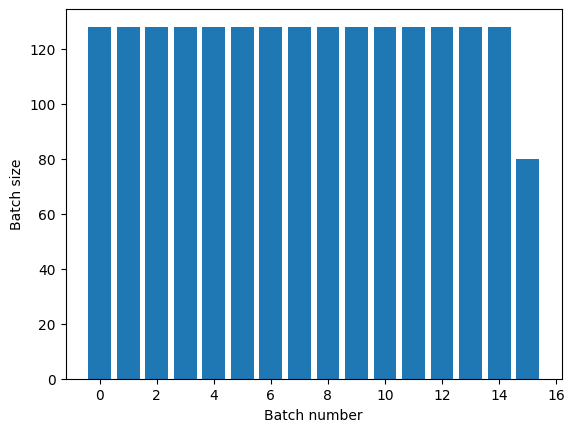

In [59]:
plot_batch_sizes(batches)

In [14]:
%qtconsole

In [15]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
target_stocks = ['AAPL', 'CMCSA', 'REGN']
training_date_start = '2012-08-13'
training_date_end = '2015-08-13'  # three years training data
training_index_start = date_to_index(training_date_start)
training_index_end = date_to_index(training_date_end)
target_history = np.empty(shape=(len(target_stocks), training_index_end - training_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), training_index_start:training_index_end, :]

In [60]:
np.ones((1, 16, 4))

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [25]:
target_history.shape

(3, 1095, 4)

In [5]:
# collect testing data
testing_date_start = '2015-08-13'
testing_date_end = '2017-08-12'
testing_index_start = date_to_index(testing_date_start)
testing_index_end = date_to_index(testing_date_end)
testing_history = np.empty(shape=(len(target_stocks), testing_index_end - testing_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), testing_index_start:testing_index_end, :]
# normalize
for i in range(target_history.shape[0]):
    for j in range(target_history.shape[1]):
        target_history[i][j] = target_history[i][j]/np.linalg.norm(target_history[i][j])
for i in range(testing_history.shape[0]):
    for j in range(testing_history.shape[1]):
        testing_history[i][j] = testing_history[i][j]/np.linalg.norm(testing_history[i][j])

In [6]:
print(target_history.shape)
print(testing_history.shape)

(3, 1095, 4)
(3, 730, 4)


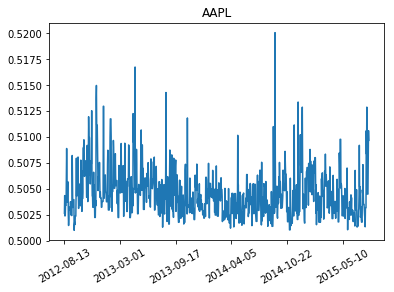

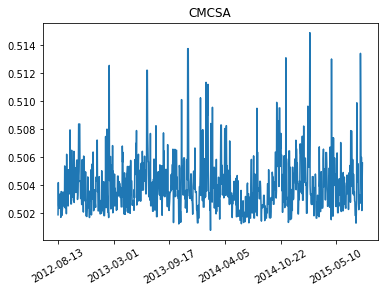

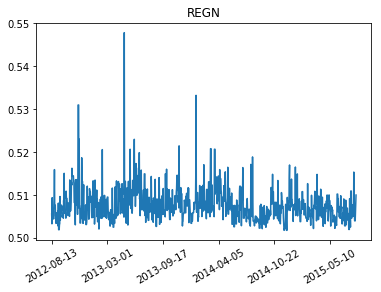

In [7]:
# visualize 3 stock open price
date_list = [index_to_date(i) for i in range(target_history.shape[1])]
x = range(target_history.shape[1])
for i in range(len(target_stocks)):
    plt.figure(i)
    plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
    plt.xticks(x[::200], date_list[::200], rotation=30)
    plt.title(target_stocks[i])
    plt.show()

In [8]:
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(target_history, target_stocks, window_length = 1)
print(env.window_length)
print(env.num_stocks)
print(env.sim.cost)

1
3
0.0025


In [9]:
# Reshape training and testing data
trainX = np.zeros(((target_history.shape[1]-env.window_length)*(env.num_stocks+1), 4, env.window_length+1, env.num_stocks))
testX = np.zeros(((testing_history.shape[1]-env.window_length)*(env.num_stocks+1), 4, env.window_length+1, env.num_stocks))
trainY = np.zeros(((target_history.shape[1]-env.window_length)*(env.num_stocks+1), env.num_stocks+1))
testY = np.zeros(((testing_history.shape[1]-env.window_length)*(env.num_stocks+1), env.num_stocks+1))
for i in range(target_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks + 1):
        for j in range(4):
            for windowIndex in range(env.window_length):
                for stock in range(env.num_stocks):
                    trainX[i*(env.num_stocks+1)+stockHeld][j][windowIndex][stock] = target_history[stock][i+env.window_length-windowIndex-1][j]
            if stockHeld > 0:
                trainX[i*(env.num_stocks+1)+stockHeld][j][env.window_length][stockHeld-1] = 1

for i in range(testing_history.shape[1]-env.window_length):
    for stockHeld in range(1, env.num_stocks + 1):
        for j in range(4):
            for windowIndex in range(env.window_length):
                for stock in range(env.num_stocks):
                    testX[i*(env.num_stocks+1)+stockHeld][j][windowIndex][stock] = testing_history[stock][i+env.window_length-windowIndex-1][j]
            if stockHeld > 0:
                testX[i*(env.num_stocks+1)+stockHeld][j][env.window_length][stockHeld-1] = 1
for i in range(target_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks+1):
        bestRate = 1.0
        bestStock = -1
        for stock in range(env.num_stocks):
            trading_cost = env.sim.cost
            if stockHeld-1 == stock:
                trading_cost = 0
            # print(trainX[i*(env.num_stocks+1) + stockHeld][3][0][stock], target_history[stock][i+env.window_length-1][3])
            rate = target_history[stock][i+env.window_length-1][3]/target_history[stock][i+env.window_length-1][0] - trading_cost
            if rate > bestRate:
                bestRate = rate
                bestStock = stock
        trainY[i*(env.num_stocks+1) + stockHeld][bestStock+1] = 1
for i in range(testing_history.shape[1]-env.window_length):
    for stockHeld in range(env.num_stocks+1):
        bestRate = 1.0
        bestStock = -1
        for stock in range(env.num_stocks):
            trading_cost = env.sim.cost
            if stockHeld-1 == stock:
                trading_cost = 0
            rate = testing_history[stock][i+env.window_length-1][3]/testing_history[stock][i+env.window_length-1][0] - trading_cost
            if rate > bestRate:
                bestRate = rate
                bestStock = stock
        testY[i*(env.num_stocks+1) + stockHeld][bestStock+1] = 1

        

In [10]:
from model.supervised.cnn import CNN
# instantiate CNN model
cnn_model = CNN(env=env)
cnn_model.build_model(load_weights=False)

Using TensorFlow backend.
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


Built model from scratch


In [11]:
# starts to train the model, hopefully it would work
cnn_model.train(trainX, trainY)

Epoch 1/10
4376/4376 [==============================] - 4s - loss: 5.8845 - acc: 0.2347     
Epoch 2/10
4376/4376 [==============================] - 4s - loss: 6.5143 - acc: 0.2514     
Epoch 3/10
4376/4376 [==============================] - 4s - loss: 5.4075 - acc: 0.2278     
Epoch 4/10
4376/4376 [==============================] - 4s - loss: 6.1577 - acc: 0.2356     - ETA: 
Epoch 5/10
4376/4376 [==============================] - 4s - loss: 5.3662 - acc: 0.2242     
Epoch 6/10
4376/4376 [==============================] - 4s - loss: 4.1719 - acc: 0.2246     
Epoch 7/10
4376/4376 [==============================] - 4s - loss: 3.9642 - acc: 0.2253     
Epoch 8/10
4376/4376 [==============================] - 4s - loss: 3.9535 - acc: 0.2233     
Epoch 9/10
4376/4376 [==============================] - 4s - loss: 4.0419 - acc: 0.2230     
Epoch 10/10
4376/4376 [==============================] - 4s - loss: 3.9527 - acc: 0.2228     
Finish.


In [85]:
# test model
predictions = cnn_model.predict(testX)
for i in range(len(predictions)):
    print(predictions[i], testY[i])
score = cnn_model.evaluate(testX, testY)
print(score)

Using Theano backend.


[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.

[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 

[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.

[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251

[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[ 0.22769251  0.21792054  0.15906529  0.3953217 ] [ 0.  0.  1.  0.]
[ 0.  0.  0.  1.

In [ ]:
ddpg_model_from_file = DDPG(env=env)
ddpg_model_from_file.build_model(load_weights=True)

In [ ]:
# evaluate the model with training data
env = PortfolioEnv(target_history, target_stocks)
observation, action = env.reset()
done = False
while not done:
    observation = observation[:, :, 3] / observation[:, :, 0]
#     print(observation)
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model_from_file.predict(observation)
    action = np.squeeze(action, axis=0)
#     print(action)
#     input('Press any key to continue...')
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
# evaluate the model with unseen data from same stock
env = PortfolioEnv(testing_history, target_stocks, steps=650, start_idx=testing_index_start, 
                   sample_start_date='2015-10-02')
observation, action = env.reset()
done = False
for i in range(10):
    observation = observation[:, :, 3] / observation[:, :, 0] * 100
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model_from_file.predict(observation)
    action = np.squeeze(action, axis=0)
#     print(action)
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
np.savez('temp/total_reward_state_1.npz', stat=ddpg_model.total_reward_stat)

In [ ]:
# plot episode reward and save it
total_reward_stat = np.load('temp/total_reward_state_1.npz')['stat']
x = range(len(total_reward_stat))[::20]
plt.plot(x, total_reward_stat[::20])
plt.xlabel('Episode')
plt.ylabel('Reward')

In [ ]:
# collect testing data of another 3 different companies
target_stocks = ['GOOGL', 'CSX', 'MAR']
testing_date_start = '2012-08-13'
testing_date_end = '2017-08-12'
testing_index_start = date_to_index(testing_date_start)
testing_index_end = date_to_index(testing_date_end)
testing_history = np.empty(shape=(len(target_stocks), testing_index_end - testing_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), testing_index_start:testing_index_end, :]

In [ ]:
# evaluate the model with unseen data from different stocks
env = PortfolioEnv(testing_history, target_stocks, steps=1700, start_idx=testing_index_start)
observation, action = env.reset()
done = False
while not done:
    observation = observation[:, :, 3] / observation[:, :, 0]
    observation = np.expand_dims(observation, axis=-1)
    action = ddpg_model.predict(observation)
    action = np.squeeze(action, axis=0)
    observation, _, done, _ = env.step(action)
env._render()

In [ ]:
ddpg_model.actor.model.save_weights(ddpg_model.actor_path)
ddpg_model.critic.model.save_weights(ddpg_model.critic_path)
ddpg_model.actor.target_model.save_weights(ddpg_model.actor_target_path)
ddpg_model.critic.target_model.save_weights(ddpg_model.critic_target_path)

In [ ]:
layer_index = 1
# check model load
ddpg_model.actor.model.get_layer(index=layer_index).get_weights()

In [ ]:
ddpg_model_from_file.actor.model.get_layer(index=layer_index).get_weights()